# Find Route Between Two location

This is an interactive demo that shows user how to use osmnx and openstreetmap to find the route between two location in the real world

### Set up the environment by importing libraries

In [1]:
import numpy as np
import osmnx as ox
import networkx as nx
import folium

import matplotlib.pyplot as plt

#Enable inline plotting of maps
%matplotlib inline

print (ox.__version__)
ox.config(log_console=True, use_cache=True)

0.11


### Defined the study area at the city of Urbana-Champaign, IL, US

In [2]:
#Define the study area
places = ['Champaign, Illinois','Urbana, Illinois']

### Read the network file at Urbana-Champaign and plot the area

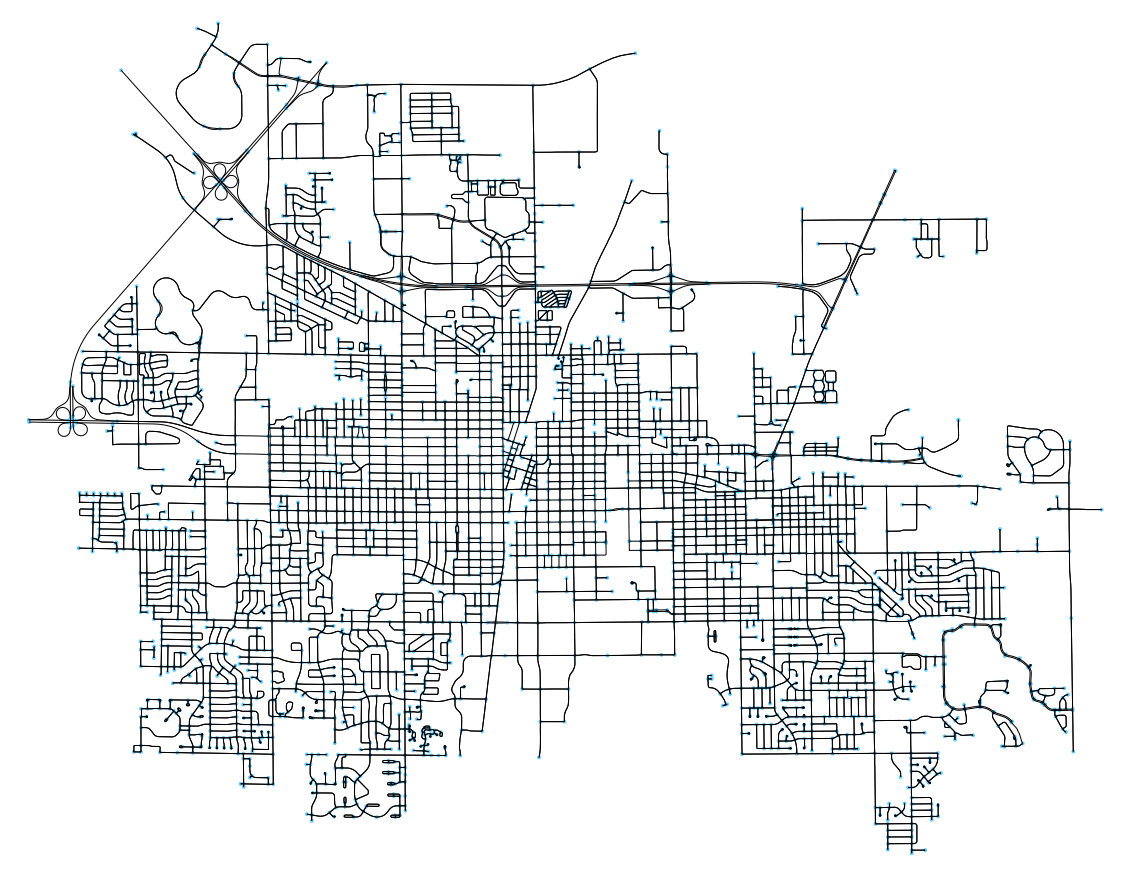

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8a6f042518>)

In [3]:
#Note - this may take some time...
# Choose one type of network
#[ 'all_private','all','drive','drive_service', 'bike','walk']:#

G = ox.graph_from_place(places, network_type='drive')

#The step give projects to UTM 
#ox.plot_graph(ox.project_graph(G));
#ox.plot_graph(G);
ox.plot_graph(G, fig_height=20, fig_width=20, edge_color='black')

#We do not save files in order to save time
#filenames = 'Urban-Champaign-Net'
#ox.save_graph_shapefile(G, filename=filenames)
#ox.save_graphml(G, filename='Urban-Champaign-Net.graphml')


### Define origin and destination location by providing longitude and latitude

Plot the origin and destination point in the network graph of Urbana-Champaign, the origin is shown in red and destination is shown in blue.

In [4]:
#origin = ox.utils.geocode('2012 S Orchard St,Urbana, IL')
#destination = ox.utils.geocode('1301 W Green St, Urbana, IL')
origin = (40.097468, -88.214171)
destination =(40.10948505, -88.2260316492452)

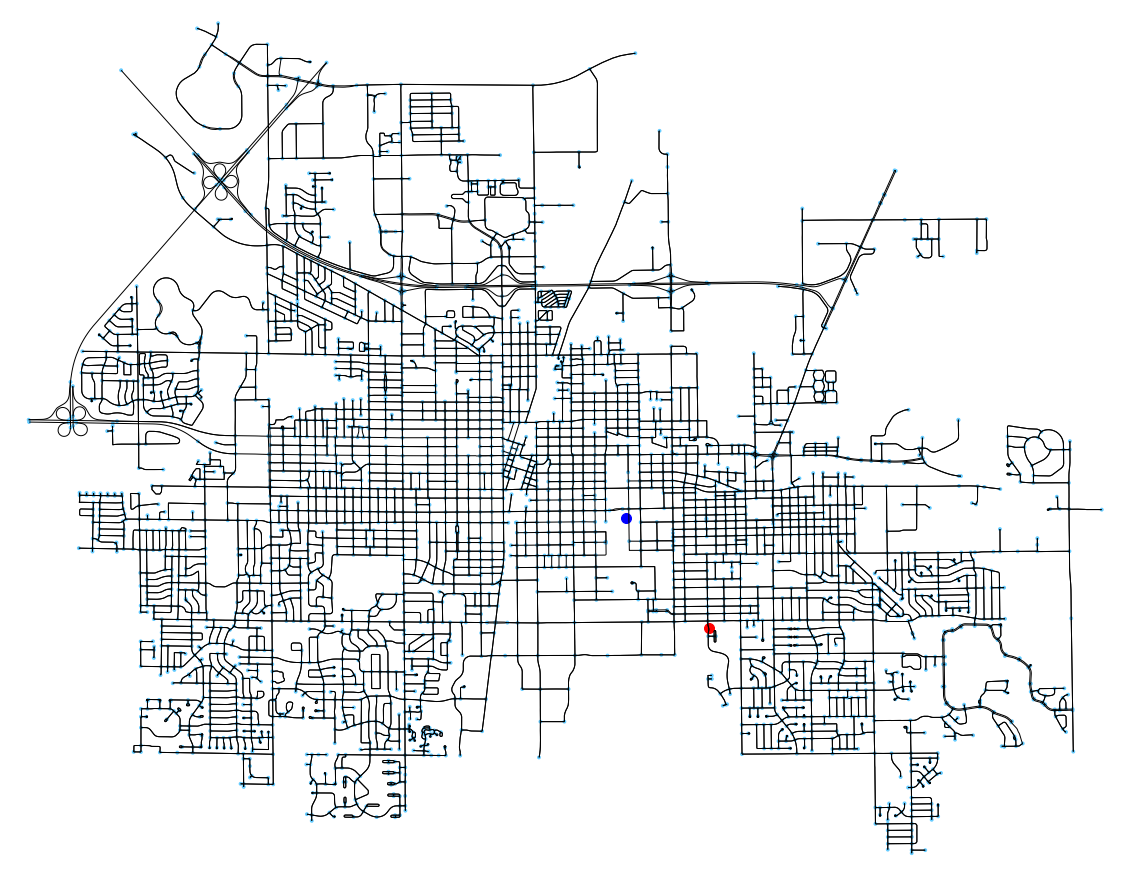

In [5]:
# Show the origin point and destination point on the map
fig, ax = ox.plot_graph(G, fig_height=20, fig_width=20, 
                        show=False, close=False, 
                        edge_color='black')

ax.scatter(origin[1], origin[0], c='red', s=100)
ax.scatter(destination[1], destination[0], c='blue', s=100)

plt.show()

In [6]:
# get the nearest network node
origin_node =  ox.get_nearest_node(G, origin) 
destination_node = ox.get_nearest_node(G, destination )

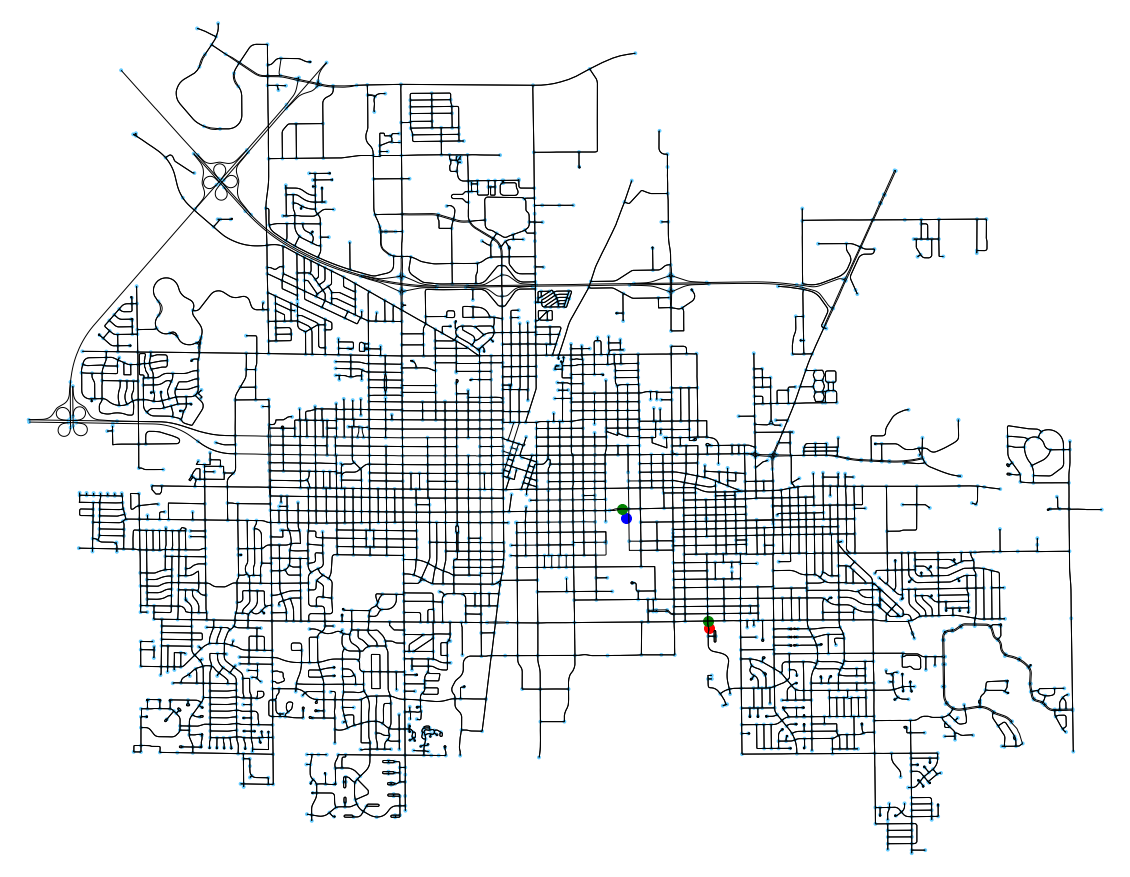

In [7]:
#Show the origin_node and the destination_node
fig, ax = ox.plot_graph(G, fig_height=20, fig_width=20, 
                        show=False, close=False, 
                        edge_color='black')

ax.scatter(origin[1], origin[0], c='red', s=100)
ax.scatter(destination[1], destination[0], c='blue', s=100)

ax.scatter(G.nodes[origin_node]['x'], G.nodes[origin_node]['y'], c='green', s=100)
ax.scatter(G.nodes[destination_node]['x'], G.nodes[destination_node]['y'], c='green', s=100)

plt.show()

### Find the shortest path between origin and destination

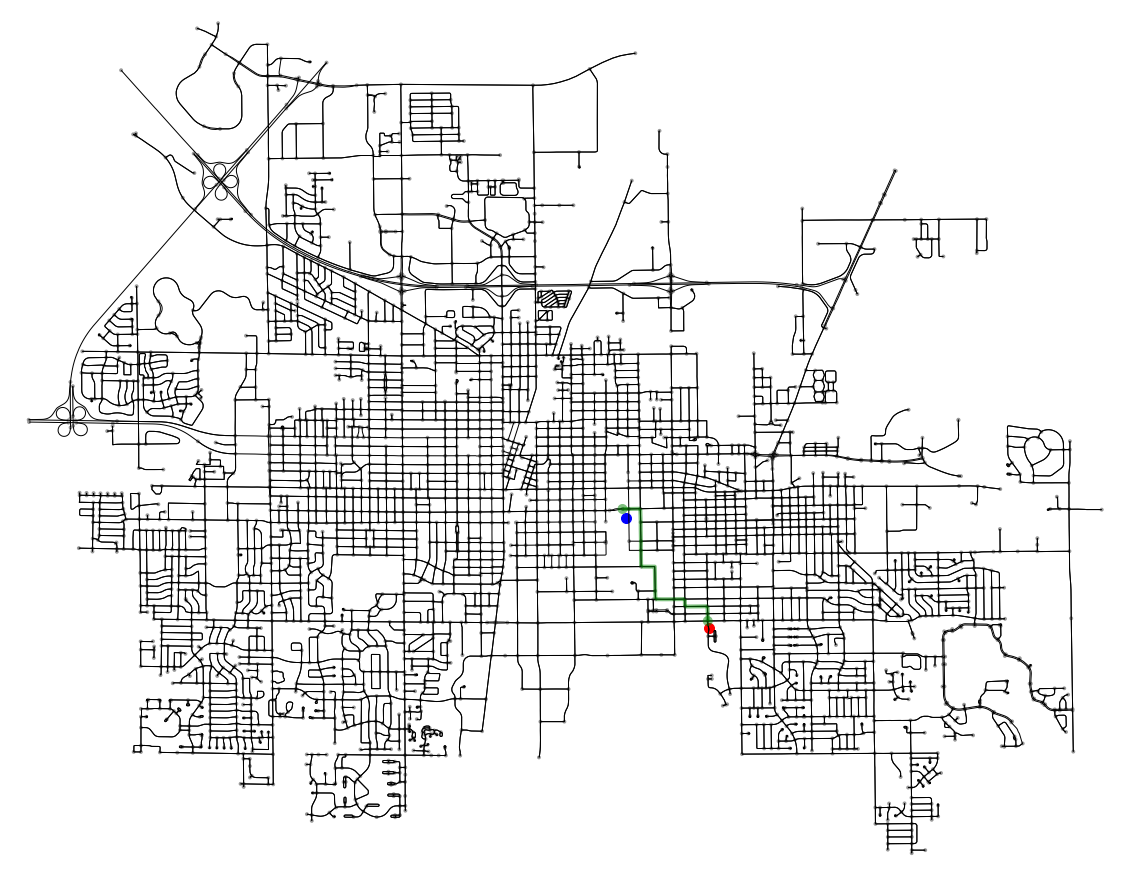

In [8]:
route = nx.shortest_path(G, origin_node, destination_node)


fig, ax = ox.plot_graph_route(G, route, fig_height=20, fig_width=20, 
                    show=False, close=False, 
                    edge_color='black',
                    orig_dest_node_color='green',
                    route_color='green')

ax.scatter(origin[1], origin[0], c='red', s=100)
ax.scatter(destination[1], destination[0], c='blue', s=100)

plt.show()

### Find the shortest distance between two random points in Urbana-Champaign

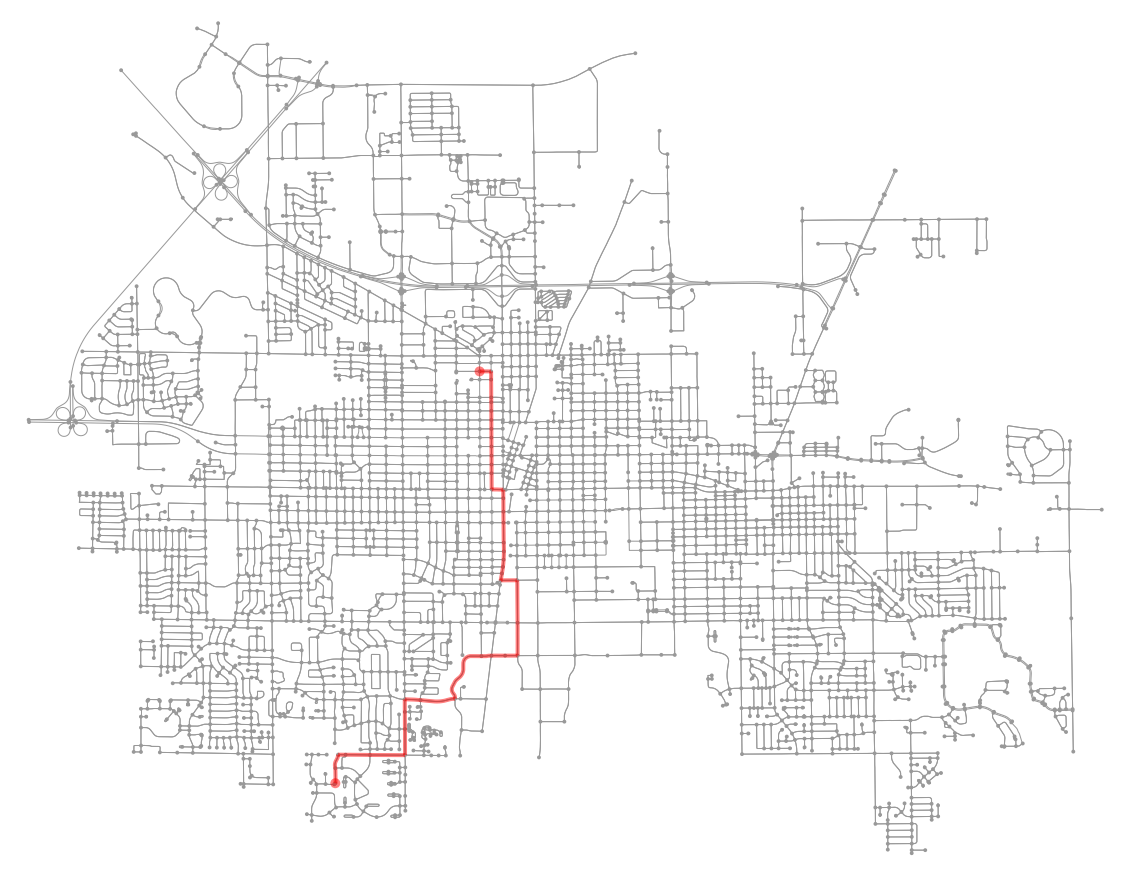

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8a770a3b38>)

In [9]:
#Using osmnx to compute the shortest path between two random nodes along road networks
route = nx.shortest_path(G, np.random.choice(G.nodes()), np.random.choice(G.nodes()))

#route = nx.shortest_path(G, np.random(G.nodes), np.random(G.nodes))
ox.plot_graph_route(G, route, fig_height=20, fig_width=20)


Walking isochrones from road network center with different time

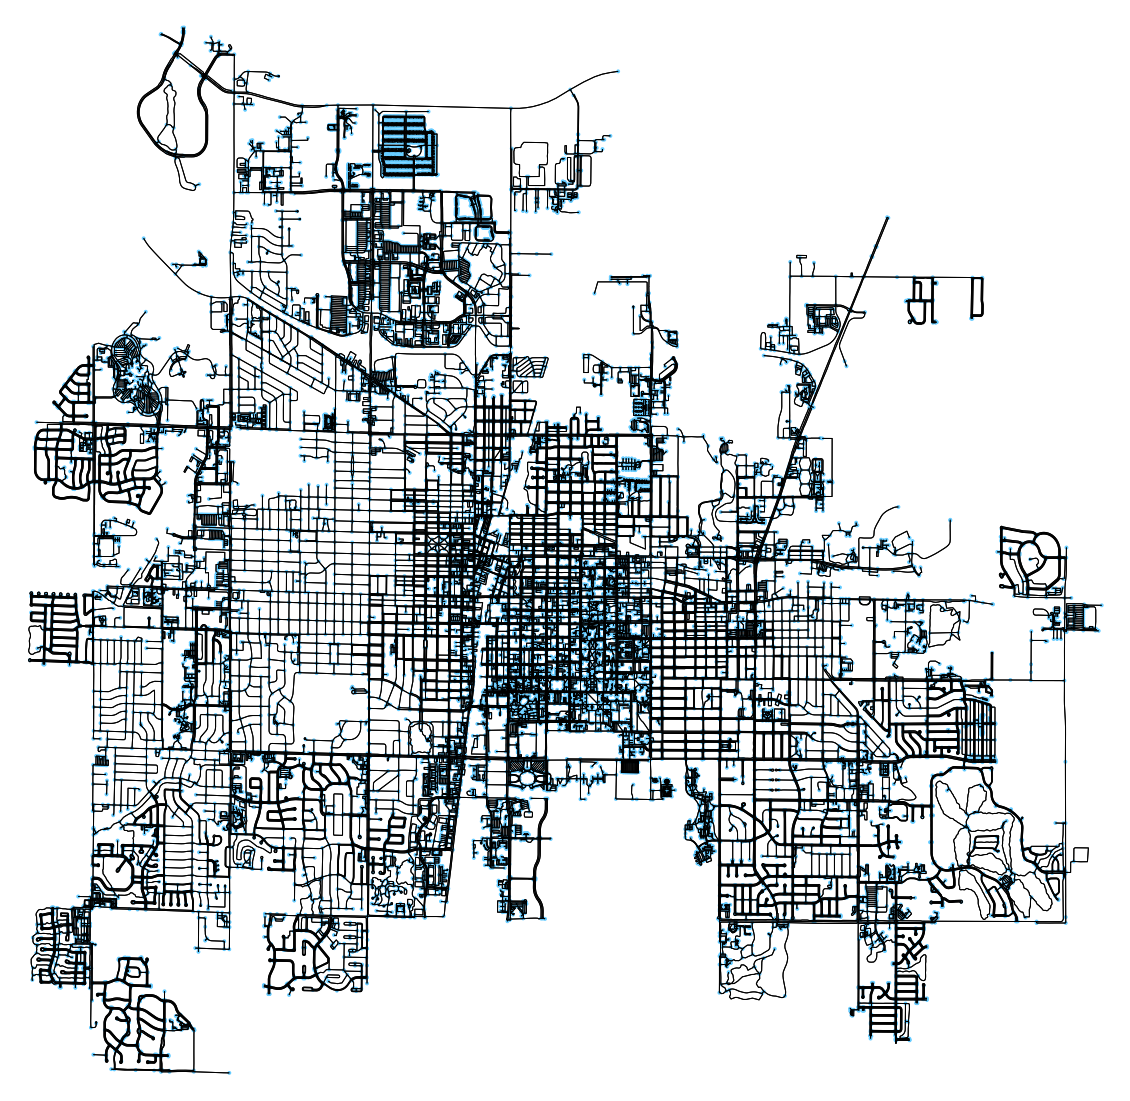

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8a51b466a0>)

In [10]:
t_network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

#Get the walk road network using osmnx
G = ox.graph_from_place(places, network_type=t_network_type)

#Get the center of the road network and retroject the road network
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

ox.plot_graph(G, fig_height=20, fig_width=20, edge_color='black')


In [11]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to meters per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [12]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

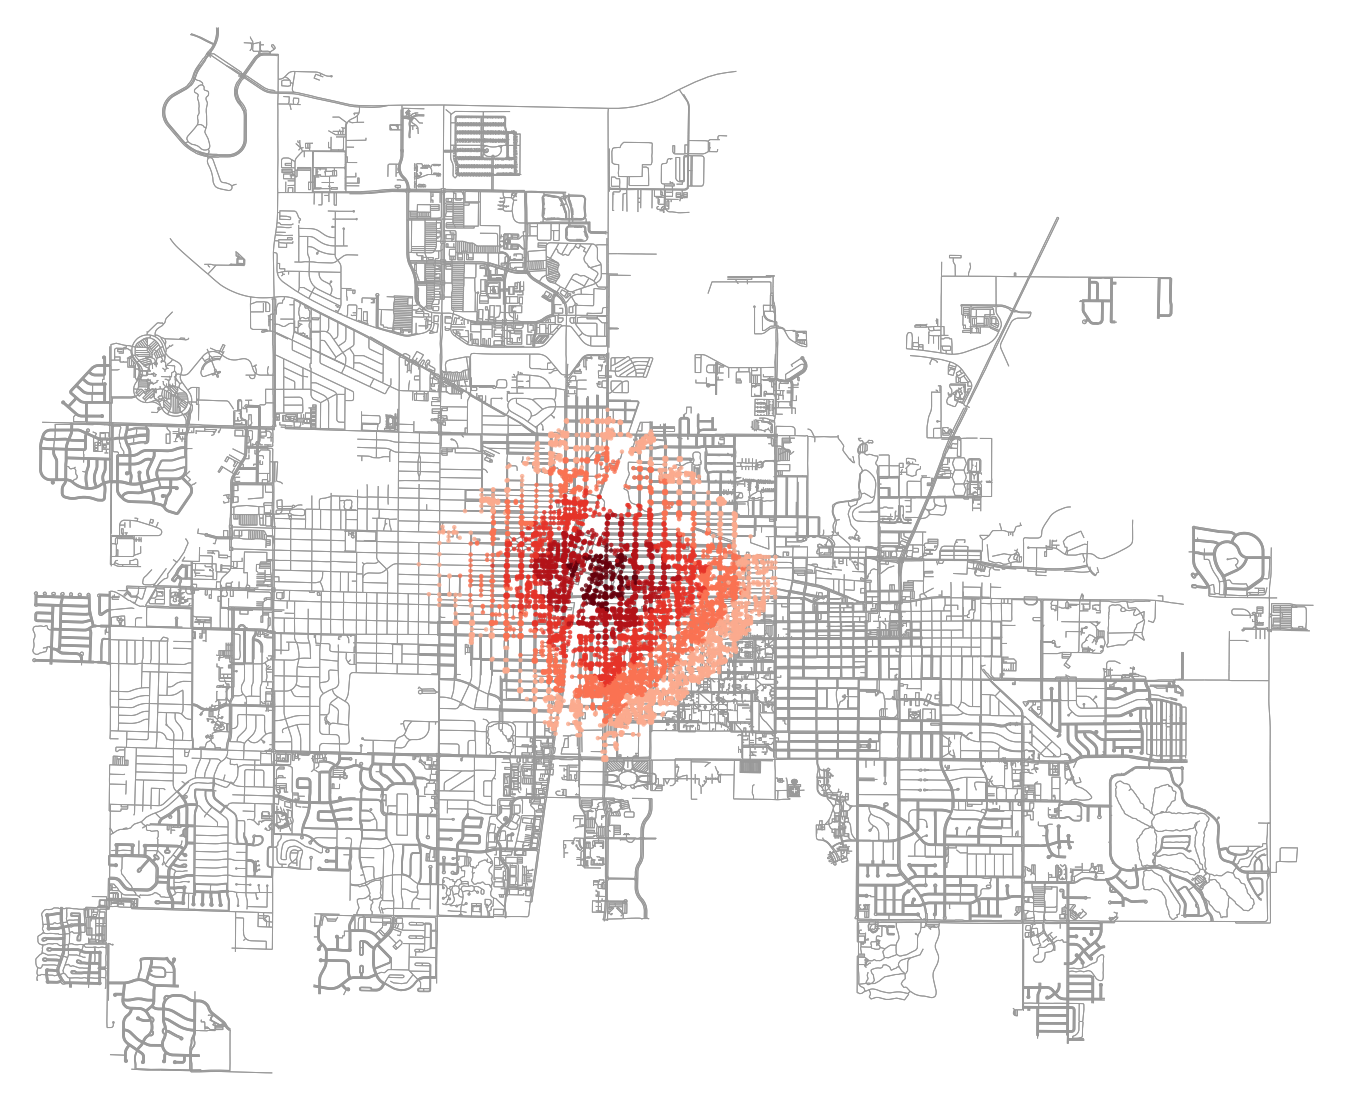

In [13]:
# color the network nodes according to isochrone then plot the road network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
# First show the isochrone nodes and then plot the road network
fig, ax = ox.plot_graph(G, fig_height=20, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

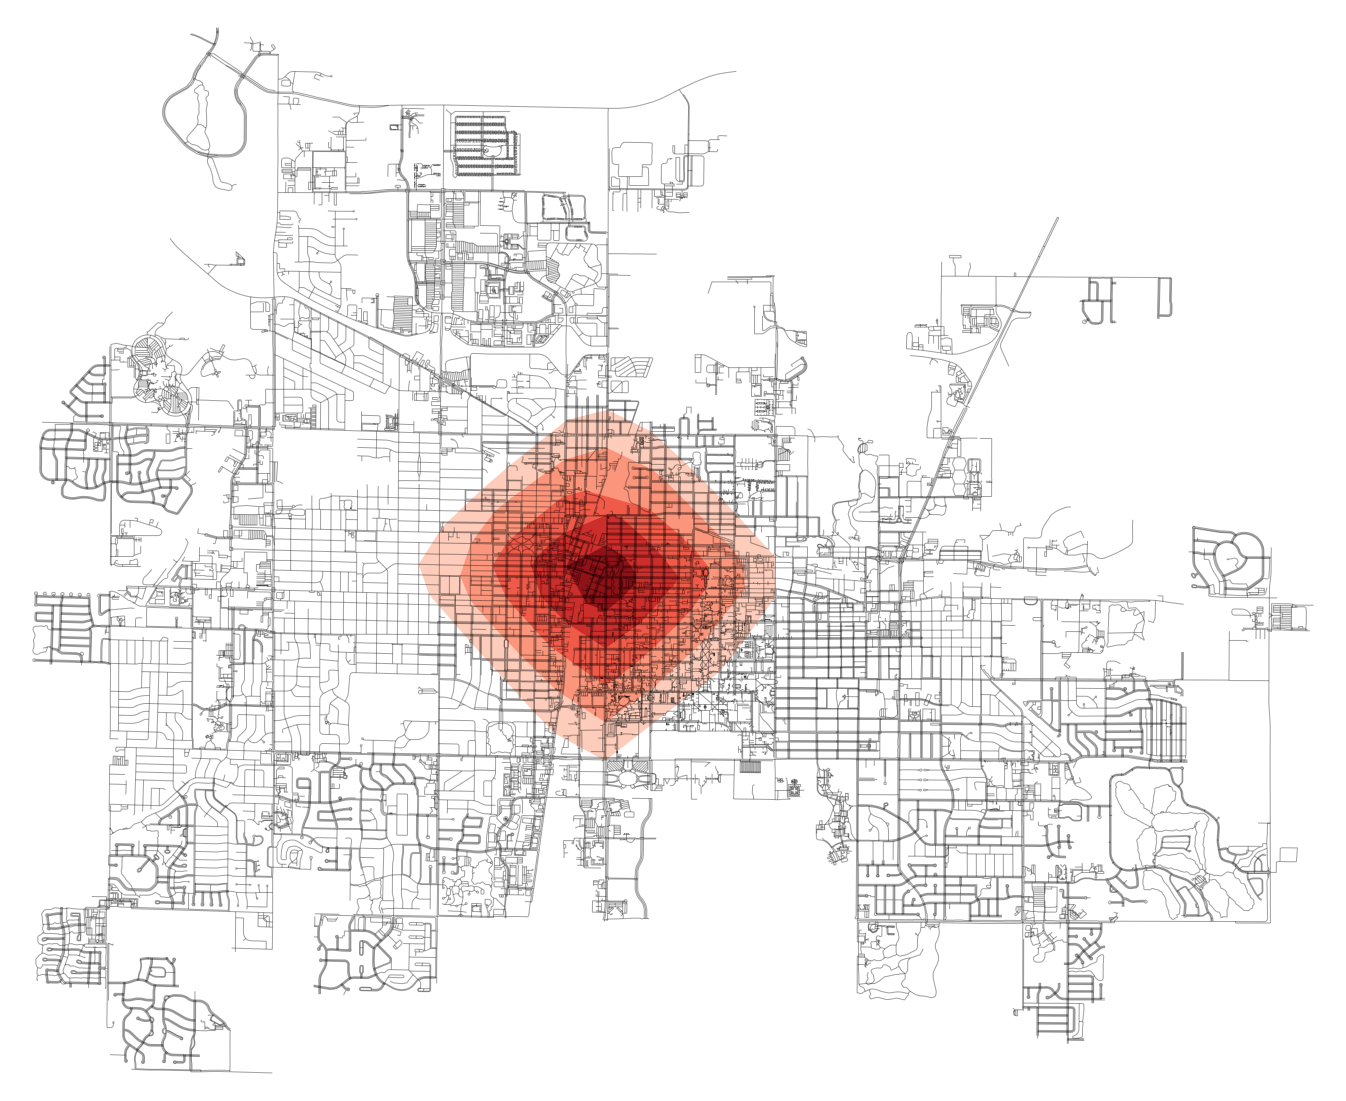

In [14]:
# make the isochrone polygons
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch
import geopandas as gpd

isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

# plot the road network, then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=20, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1) #-1
    ax.add_patch(patch)
plt.show()